In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import ngrams
import nltk
import re
import string
import urllib.request
import requests
import bs4 as bs
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.decomposition import PCA,LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from textblob import TextBlob,Word

# Getting the data

we built a crawler to scrape BeyondBlue, which is a forum for depressed people, who lives only in Australia.
extracting only TEXT,DATE, and NAME.

In [ ]:
# do not run -
#did it twice

#getting english data:
def getlinks(soup):
    l = []
    for link in soup.find_all('a',class_ = "sfforumThreadTitle",href = True):
        l.append(link['href'][3:])
    return l

def getdate(soup):
    l = []
    div = soup.find('div', class_ = 'sfforumPostAge')
    return(div.text)
#
def getname(soup):
    l = []
    div = soup.find('span', class_ = 'sfforumUser') 
    return([div.text])   
#
def gettext(soup):
    p = soup.find('div', class_ = 'postAndSig')
    return p.text
#

sitelist = []
site = 'https://www.beyondblue.org.au/get-support/online-forums/depression'
string = '/page/'

for i in range(2,36): # then i did 36 - 75
    sitelist.append(site + string + str(i))
#making the dataframe:
dftoappend = pd.DataFrame()
df = pd.DataFrame()

for sites in sitelist:
    print(sites)
    sauce = urllib.request.urlopen(sites)
    soup = bs.BeautifulSoup(sauce,'html.parser')
    links = getlinks(soup)
    for link in links:
        sauce = urllib.request.urlopen(site + '/' + link)
        soup = bs.BeautifulSoup(sauce,'html.parser')
        date = getdate(soup)
        name = getname(soup)
        text = gettext(soup)
        d = [{'DATE' : date, 'NAME' : name, 'TEXT' : text}]
        dftoappend = pd.DataFrame(d)
        df = df.append(dftoappend,ignore_index = True)
df.to_csv('newenglishPostsall1.csv')

In [56]:
# Saving the data
english = pd.read_csv('newenglishPostsall1.csv')
df2 = pd.read_csv('newenglishPostsall2.csv')

english = english.append(df2,ignore_index = True)
english.head()

,Unnamed: 0,DATE,NAME,TEXT
0,0,\n \n ...,['Aliza221'],\nHmm... where should i even begin. This is a ...
1,1,\n \n ...,['Hiking_Eeyore'],\nI am struggling with this fight against depr...
2,2,\n \n ...,['StevoP'],"\nGuy is just bringing me down, have no clue w..."
3,3,\n \n ...,['StevoP'],"\nBut yep depression, low mood incredibly stro..."
4,4,\n \n ...,['a of n'],"\nHi ,\nIm into my ninth year of depression \n..."


In [80]:
neutral_post = pd.read_csv('insight/neutral_posts.csv')
neutral_post.drop(neutral_post.columns.difference(['user_name','date_created','post_text']), 1, inplace=True)
neutral_post.columns = ['TEXT','DATE','NAME']
neutral_post['DEPRESSED'] = 0
newenglish['DEPRESSED'] = 1
neutral_post.head()

,TEXT,DATE,NAME
0,i dont remember the title or any character nam...,2018-06-23 04:14:04,ziamal
1,believe me ive listened to a bladee song twice...,2018-11-05 22:58:20,yunglean2001
2,imgur having trouble on my phone idk why. here...,2018-08-30 22:39:40,yunglean2001
3,i dont think its fair to shit on drain over pr...,2018-07-24 04:43:48,yunglean2001
4,was watching the spellbound video and of cours...,2018-03-22 19:41:58,yunglean2001


## extracting basic features
First, we will extract all the feature we can from the uncleaned data(description below)
we will count the words, the characters,the numerics, the number of spaces, whether they tag something, the number of stopwords(description below), and the lexical divercity.

In [7]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len([words]))

def pipeline(train1, whatstop):
    train1['LINE_NUM'] = train1['TEXT'].apply(lambda x: str(x).count('\n') - 2)
    train1['WORD_COUNT'] = train1['TEXT'].apply(lambda x: len(str(x).split(" ")))
    train1['CHAR_COUNT'] = train1['TEXT'].str.len() ## this also includes spaces
    train1['TEXT'] = train1['TEXT'].apply(lambda x: re.sub(r'\n',' ',x))
    train1['TEXT'] = train1['TEXT'].str.replace(r'\s+',' ')
    train1['TAG'] = train1['TEXT'].str.contains('@')
    train1['STOPWORDS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x in whatstop]))
    train1['HASHTAGS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
    train1['UPPER'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))
    train1['NUMERICS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
    #train1['AVG_WORDS_LEN'] = train1['TEXT'].apply(lambda x: avg_word(str(x)))
    train1['AVG_WORDS_LEN'] = train1['CHAR_COUNT'] / train1['WORD_COUNT'] # including spaces
    #lexical divercity
    train1['LEXICAL_DIVER'] = train1['TEXT'].apply(lambda x: len(x) / len(set(x)))
    return train1

in order to count the stopwords and use it afterwards to clean the data, we will use a set from nltk.corpus, and add more words manually, this stage is importent and we will get to this frequently, in order to clean the text better.

In [74]:
#adding stop words manually and automaticly
# removing words isnt counted as stop words but they are words i'd like to remove later on
additional_stopwords = "you that him to it her there etc know want one hey hi yep well really hello a like don't about above after again against all am an and any are aren't as at be because been before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or other oughtour ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves"
removing_words = 'beyondblue beyond blue tony wk tony geoff neil depression'
englishstop = stopwords.words("english")
englishstop += additional_stopwords.split()
englishstop += removing_words.split()
nopunc = re.sub("'",'',additional_stopwords)
englishstop += nopunc.split()
englishstop = set(englishstop)

In [85]:
#getting the basic feature extraction from the depressed and undepressed posts
english = pipeline(english,englishstop)
neutral_post = pipeline(neutral_post,englishstop)
#english.drop(columns = 'Unnamed: 0',inplace = True)
english.head()

,DATE,NAME,TEXT,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER,WORKING_TEXT
0,3 June 2019,['Aliza221'],Hmm... where should i even begin. This is a f...,-2,503,2498,False,262,0,14,2,4.966203,50.979592,hmm even begin first spoken people life circle...
1,3 June 2019,['Hiking_Eeyore'],I am struggling with this fight against depre...,-2,440,2286,False,199,0,32,6,5.195455,46.653061,struggling fight began think strong keep going...
2,6 June 2019,['StevoP'],"Guy is just bringing me down, have no clue wh...",-2,83,439,False,45,0,0,0,5.289157,13.303030,guy bringing clue affecting clearly entire sor...
3,1 June 2019,['StevoP'],"But yep depression, low mood incredibly stron...",-2,64,320,False,31,0,1,0,5.000000,8.648649,low mood incredibly strong hate anyway liverpo...
4,2 June 2019,['a of n'],"Hi , Im into my ninth year of depression It s...",-2,460,2378,False,203,0,22,5,5.169565,52.844444,ninth year started marriage breakdown tends de...


In [75]:
english.describe()

,LINE_NUM,WORD_COUNT,CHAR_COUNT,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER
count,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000,3579.000000
mean,4.377759,251.824811,1321.961442,117.716960,0.000559,14.404023,1.444258,5.262153,31.420659
std,6.853601,164.344691,862.489163,78.463127,0.023636,11.545905,1.987920,0.347010,16.741107
min,0.000000,8.000000,42.000000,2.000000,0.000000,0.000000,0.000000,2.980287,2.470588
25%,0.000000,128.000000,674.000000,59.000000,0.000000,6.000000,0.000000,5.044603,18.782517
50%,3.000000,217.000000,1144.000000,102.000000,0.000000,12.000000,1.000000,5.231293,29.200000
75%,6.000000,363.000000,1914.000000,170.000000,0.000000,21.000000,2.000000,5.430083,43.105336
max,136.000000,1920.000000,9399.000000,1033.000000,1.000000,106.000000,37.000000,9.210526,153.262295


In [76]:
english.corr()

,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER
LINE_NUM,1.000000,0.304540,0.336998,0.040934,0.293752,0.010774,0.237253,0.131274,0.259939,0.297162
WORD_COUNT,0.304540,1.000000,0.995298,0.040611,0.985550,0.005493,0.770452,0.450092,-0.055764,0.963722
CHAR_COUNT,0.336998,0.995298,1.000000,0.044229,0.976868,0.006787,0.755202,0.448212,0.018803,0.961572
TAG,0.040934,0.040611,0.044229,1.000000,0.040384,-0.001047,0.017076,0.041013,0.019794,0.037697
STOPWORDS,0.293752,0.985550,0.976868,0.040384,1.000000,-0.000065,0.721612,0.426544,-0.089640,0.962001
HASHTAGS,0.010774,0.005493,0.006787,-0.001047,-0.000065,1.000000,0.001221,0.000663,0.004185,-0.002050
UPPER,0.237253,0.770452,0.755202,0.017076,0.721612,0.001221,1.000000,0.304342,-0.148290,0.738994
NUMERICS,0.131274,0.450092,0.448212,0.041013,0.426544,0.000663,0.304342,1.000000,-0.018163,0.366542
AVG_WORDS_LEN,0.259939,-0.055764,0.018803,0.019794,-0.089640,0.004185,-0.148290,-0.018163,1.000000,-0.044370
LEXICAL_DIVER,0.297162,0.963722,0.961572,0.037697,0.962001,-0.002050,0.738994,0.366542,-0.044370,1.000000


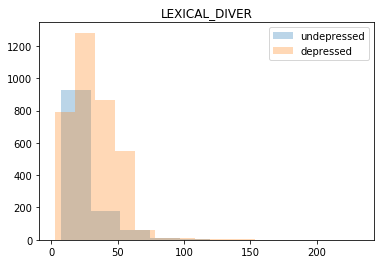

In [179]:
#plotting some differences from basic extraction
plt.hist(neutral_post['LEXICAL_DIVER'],label = 'undepressed',alpha = 0.3)
plt.hist(english['LEXICAL_DIVER'],label = 'depressed',alpha = 0.3)
plt.title('LEXICAL_DIVER')
plt.legend()
plt.show()

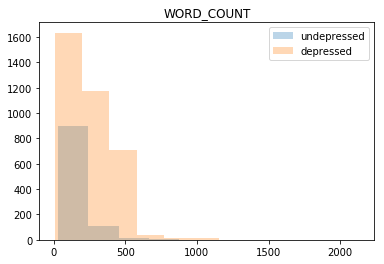

In [77]:
#plotting some differences from basic extraction
plt.hist(neutral_post['WORD_COUNT'],label = 'undepressed',alpha = 0.3)
plt.hist(english['WORD_COUNT'],label = 'depressed',alpha = 0.3)
plt.title('WORD_COUNT')
plt.legend()
plt.show()

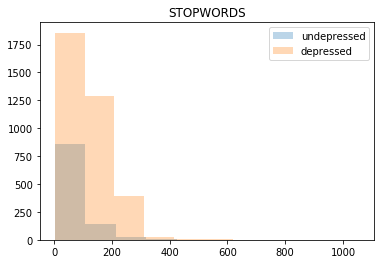

In [78]:
#plotting some differences from basic extraction
plt.hist(neutral_post['STOPWORDS'],label = 'undepressed',alpha = 0.3)
plt.hist(english['STOPWORDS'],label = 'depressed',alpha = 0.3)
plt.title('STOPWORDS')
plt.legend()
plt.show()

## cleaning the data

In [35]:
def cleanpipe(train1,whatstop):
    train1['DATE'] = train1['DATE'].str.replace('[\n\t\t\t]','')
    train1['DATE'] = train1['DATE'].str.strip()
    train1['WORKING_TEXT'] = train1['TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'\d+',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'[^\w\s]',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'\s+',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x:" ".join(x for x in x.split() if (x not in whatstop)))
   
    #removing links, and words under 2 chars
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(x.startswith('www'))))
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(x.startswith('http'))))                
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(len(x)< 2)))                

    #removing posts less then 8 words
    train1.drop(train1[train1['WORD_COUNT'] < 8].index,inplace = True)
    
    #lemmatization and stemming isnt really halpful, making alot of noise words, chose to ignore this.
    #lemmatization
    #train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    #stemming isnt really effective here just adding more words
    #st = PorterStemmer()
    #train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    
    train1 = train1.drop_duplicates(subset = 'WORKING_TEXT')
    return train1


##remove freq word function
def freqremovel(train1, freq):
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x in freq))
    return train1

In [86]:
#cleaning the text
newenglish = cleanpipe(english,englishstop)
neutral_post = cleanpipe(neutral_post,englishstop)

In [65]:
#saving point.
#newenglish.to_csv('insight/DTMenglish.csv')
newenglish = pd.read_csv('insight/DTMenglish.csv')
newenglish.dropna(inplace = True)
newenglish.drop(columns = ['Unnamed: 0'],inplace = True)
newenglish.head()
newenglish

,DATE,NAME,TEXT,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER,WORKING_TEXT
0,\n ...,['Aliza221'],Hmm... where should i even begin. This is a f...,1,502,2500,False,262,0,14,2,4.980080,50.979592,hmm even begin first spoken people life circle...
1,\n ...,['Hiking_Eeyore'],I am struggling with this fight against depre...,7,435,2290,False,199,0,32,6,5.264368,46.653061,struggling fight began think strong keep going...
2,\n ...,['StevoP'],"Guy is just bringing me down, have no clue wh...",0,83,441,False,45,0,0,0,5.313253,13.303030,guy bringing clue affecting clearly entire sor...
3,\n ...,['StevoP'],"But yep depression, low mood incredibly stron...",0,64,322,False,31,0,1,0,5.031250,8.648649,low mood incredibly strong hate anyway liverpo...
4,\n ...,['a of n'],"Hi , Im into my ninth year of depression It s...",16,451,2387,False,203,0,22,5,5.292683,52.844444,ninth year started marriage breakdown tends de...
5,\n ...,['Cookie_cookie'],"How to people mange when life if great, work ...",0,23,123,False,11,0,0,0,5.347826,4.920000,people mange life great work family friends th...
6,\n ...,['Rod_NR93'],I'm not doing too well. I had been feeling mu...,3,151,796,False,67,0,10,0,5.271523,23.352941,feeling much better year despite ups downs alo...
7,\n ...,['Leo28'],"Hi all, I have a question about quitting SSRI...",7,218,1212,False,113,0,10,1,5.559633,28.833333,question quitting ssris irritability slowly ta...
8,\n ...,['Paullus'],I've been doing really well the past year or ...,8,83,449,False,43,0,0,1,5.409639,12.514286,past year two swirling black dog returned veng...
9,\n ...,['Busymum'],"Hi, I haven't been on for a while - I'm just ...",1,78,413,False,41,0,1,1,5.294872,11.472222,motivated nearly still trying figure reason de...


## date analysis

In [23]:
# arrange the date
def DATEChange(date):
    for i in range(0,len(date)): 
        match = re.search(r"(\d+)(\s)(\w+)(\s)(\d+)", date[i])
        if(match):
            date[i] = re.sub(r'(\d+)(\s)(\w+)(\s)(\d+)',r'\3\2\5\2\1', date[i])
    return date

# plotting the date
def TimeBarPlot(df_EN):    
    fig = plt.figure(figsize=(20, 20))
    fig1 = fig.add_subplot(3,3,1)
    fig1 = df_EN['DATE'].groupby(df_EN["DATE"].dt.month).count().plot(title = "Months",kind = "bar",color = 'g',grid = True)
    fig2 = fig.add_subplot(3,3,2)
    fig2 = df_EN['DATE'].groupby(df_EN["DATE"].dt.day).count().plot(title = "Day of month",kind = "bar",color = 'b',grid = True)
    fig3 = fig.add_subplot(3,3,3)
    fig3 = df_EN['DATE'].groupby(df_EN["DATE"].dt.weekday).count().plot(title = "WeekDay",kind = "bar",color = 'r',grid = True)
    plt.show

In [ ]:
#plotting and arranging the data to datetime foramt
newenglish["DATE"] = DATEChange(newenglish['DATE'])
for i in range(0,len(df1)):
    newenglish['DATE'][i] = datetime.strptime(newenglish['DATE'][i], '%B %Y %d')

TimeBarPlot(newenglish)

for i in range(0,len(neutral_post)):
    neutral_post['DATE'][i] = datetime.strptime(neutral_post['DATE'][i], '%Y-%m-%d %X')

TimeBarPlot(neutral_post)

## frequent word removel and word cloud

In [72]:
#removing frequent words
englishfreq = pd.Series(' '.join(newenglish['WORKING_TEXT']).split()).value_counts()[220:-600]
newenglish = freqremovel(newenglish,englishfreq)

neutral_freq = pd.Series(' '.join(neutral_post['WORKING_TEXT']).split()).value_counts()[150:-200]
neutral_post = freqremovel(neutral_post,neutral_freq)

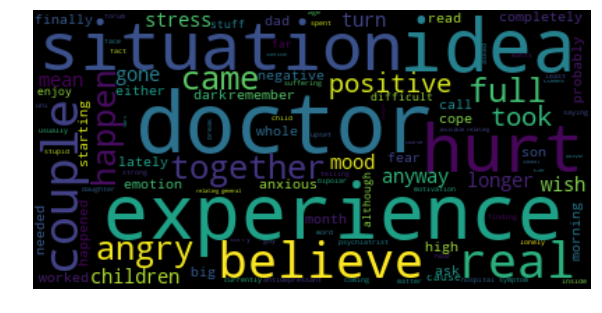

In [73]:
# extract the datataset in raw format and making wordcloud
# did this twice, depressed and undepressed
def PostWordCloud(df):
    string = ''
    for line in df['WORKING_TEXT']:
        string = string + str(line)
    
    wordcloud = WordCloud(background_color='black',max_font_size=60).generate(string)
    plt.figure(figsize=(10,10))
    
    #plot wordcloud in matplotlib
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
PostWordCloud(newenglish)

## Advenced Text Processing

### n-grams

In [88]:
#getting whole posts as one text
def getstring(df):
    string = ''
    for line in df['TEXT']:
        string = string + str(line)
    return(string)

#finding n-grams
def getngrams(strings, n):
    ngram_counts = Counter(ngrams(strings.split(),n))
    ngram_counts = ngram_counts.most_common()
    n_grams_freq = pd.DataFrame(ngram_counts)
    n_grams_freq['string'] = n_grams_freq[0].apply(lambda x:','.join(x))
    return n_grams_freq

In [90]:
#getting the bi-grams and printing them
strings = getstring(newenglish)
n2gramenglish = getngrams(strings,2)
n2gramenglish.head()

,0,1,string
0,"(I, have)",5514,"I,have"
1,"(I, am)",4374,"I,am"
2,"(and, I)",3101,"and,I"
3,"(I, feel)",2923,"I,feel"
4,"(I, was)",2606,"I,was"


### POS and dictionary

In [14]:
## get dictionary words
def getdict(adjCorpus):
    wordSet = set()
    newdf = pd.DataFrame()
    for word in adjCorpus['WORKING_TEXT']:
        words = (TextBlob(str(word)).words)
        words = list(words)
        wordSet.update(words)
        #adjCorpus['WORDS'] = words
        #words = TextBlob(corpus['post_text']).words
    return wordSet
#getting Part of speech for each word

def getPOStags(mydict):
    pos_tags = nltk.pos_tag(mydict)
    pos_tags_df = pd.DataFrame(pos_tags,columns = ['words','POS'])
    countPOS = pos_tags_df.groupby('POS').count()
    return pos_tags_df,countPOS

In [47]:
#making dictionaries
englishdict = getdict(newenglish) # 1006 #920 # 917
# getting POS tags and count
english_POS,english_POS_count = getPOStags(englishdict)

#making dictionaries
neutral_posts_dict = getdict(neutral_post) # 1006 #920 # 917
# getting POS tags and count
neutral_pos,neutral_POS_count = getPOStags(neutral_posts_dict)

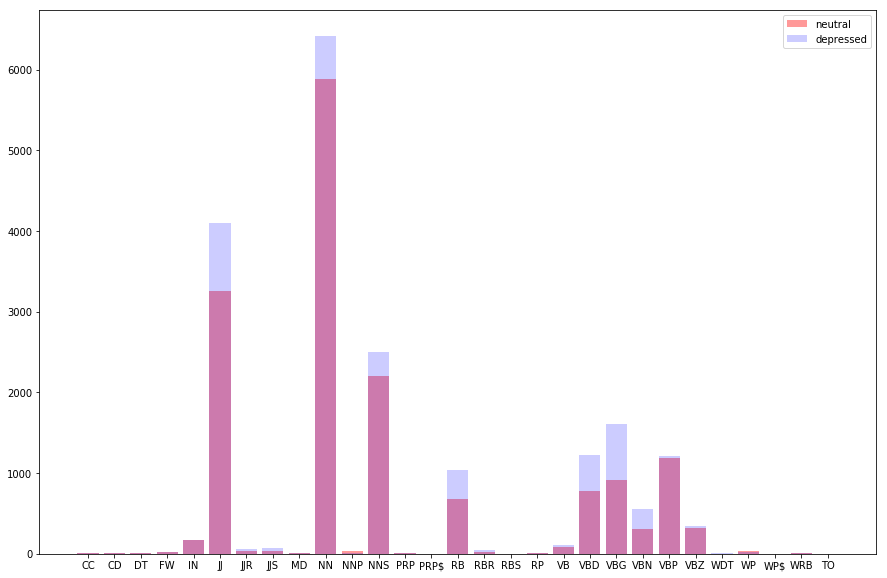

In [49]:
#plotting the POS
plt.figure(figsize=(15,10))
plt.bar(neutral_POS_count.index,neutral_POS_count['words'],color = 'red',alpha = 0.4,label = 'neutral')
plt.bar(english_POS_count.index,english_POS_count['words'],color = 'blue',alpha = 0.2,label = 'depressed')
plt.legend()
plt.show()

## sentiment analysis

In [81]:
#sentiment analysis using textblob
#defining two functions that will translate words to polarity and subjectivity and then calculate the whole post.
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

[]

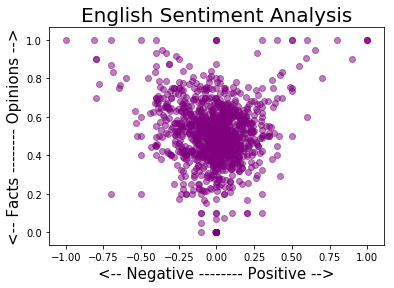

In [153]:
#plotting the analysis for depressed posts
newenglish['polarity'] = newenglish['WORKING_TEXT'].apply(pol)
newenglish['subjectivity'] = newenglish['WORKING_TEXT'].apply(sub)
plt.scatter(newenglish['polarity'][:1100],newenglish['subjectivity'][:1100], c = 'purple',alpha = 0.5)
plt.title('English Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
plt.plot()

[]

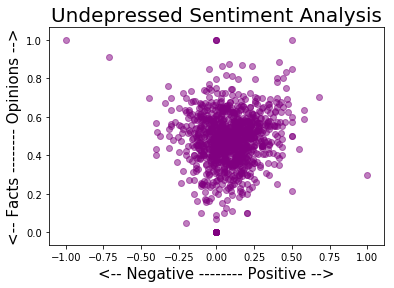

In [87]:
#plotting the analysis for neutral posts
neutral_post['polarity'] = neutral_post['WORKING_TEXT'].apply(pol)
neutral_post['subjectivity'] = neutral_post['WORKING_TEXT'].apply(sub)
plt.scatter(neutral_post['polarity'],neutral_post['subjectivity'], c = 'purple',alpha = 0.5)
plt.title('Undepressed Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
plt.plot()

In [ ]:
#finding the differences between them
newenglish[:1100][newenglish['polarity'] > 0.25].count() # 71             #POSITIVE
neutral_post[neutral_post['polarity'] > 0.25].count() #110
newenglish[:1100][newenglish['subjectivity'] > 0.6].count() #279           #OPINION
neutral_post[neutral_post['subjectivity'] > 0.6].count() #274
##
newenglish[:1100][newenglish['polarity'] < -0.25].count() # 115              #NEGATIVE
neutral_post[neutral_post['polarity'] < -0.25].count() # 56
newenglish[:1100][newenglish['subjectivity'] < 0.4].count() #255          #FACT
neutral_post[neutral_post['subjectivity'] < 0.4].count() #256

## Topic modeling

In [21]:
#using count vectorizer, with default parameters creating a sparse matrix
bow = CountVectorizer()
A = bow.fit_transform(newenglish['WORKING_TEXT'])

<3579x258757 sparse matrix of type '<class 'numpy.int64'>'
	with 669012 stored elements in Compressed Sparse Row format>

In [91]:
# Define Search Param

search_params = {'n_components': [3,4,5], 'x': [.7,.9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(A)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [3, 4, 5], 'learning_decay': [0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
#using thr best lda model and getting components
best_lda_model = model.best_estimator_
W = best_lda_model.fit_transform(A)
H = best_lda_model.components_

In [25]:
# column names to best_lda_model.n_topics
topicnames = ["Topic" + str(i) for i in range(1,4)]

# index names
docnames = ["Doc" + str(i) for i in range(0,len(newenglish))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(W,2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)

In [26]:
#converting to np array to use argmax and find the dominant topic
df_document_topic = pd.DataFrame(W)
df_document_topic_array = np.array(W)
dominant_topic = np.argmax(df_document_topic_array, axis=1)

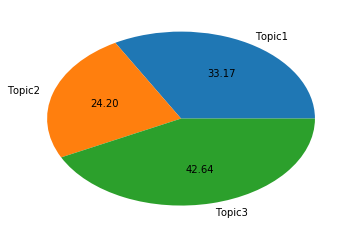

In [27]:
#plotting the devision of the topics
topics = pd.DataFrame(dominant_topic)
topics.reset_index(inplace = True)
#grouping by the topics
count = topics.groupby(0).count()
count = count['index']
plt.pie(count,labels = ['Topic1','Topic2','Topic3'],autopct ='%.2f')
plt.show()

In [28]:
# defining function that show the topics
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
terms = bow.get_feature_names()

for topic_index in range(3):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feel, get, time, work, years, life, help, go, feeling, going
Topic 02: feel, time, people, get, life, years, even, things, back, think
Topic 03: feel, life, get, time, years, work, help, even, people, things


In [29]:
#making a dataframe of the topics
df = pd.DataFrame(descriptors)
df = df.transpose()
df.columns = ['Topic1','Topic2','Topic3']
df

,Topic1,Topic2,Topic3
0,feel,feel,feel
1,get,time,life
2,time,people,get
3,work,get,time
4,years,life,years
5,life,years,work
6,help,even,help
7,go,things,even
8,feeling,back,people
9,going,think,things


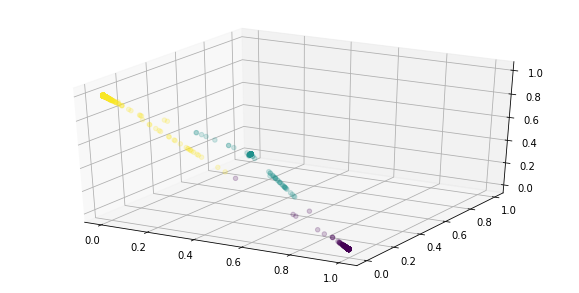

In [30]:
#plotting to see how the model devided the topics
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)  
ax = fig.add_subplot(111, projection='3d',)
ax.scatter(df_document_topic[0],df_document_topic[1],df_document_topic[2],c = dominant_topic,alpha = 0.2)
plt.show()

# showing differently with pca

In [31]:
# Principal component analysis using tf-idf vectorizer
bow = TfidfVectorizer(max_features=1000000, lowercase=True, ngram_range=(1,1),analyzer = "word")
#fitting the data
train_data_features = bow.fit_transform(newenglish['WORKING_TEXT'])
#lda doesn't work with sparse matrix, used truncatedSVD
svd = TruncatedSVD(n_components=3) 
## transform the model to data 
data = svd.fit_transform(train_data_features) #vectors = pd.DataFrame(train_data_features)
#making a new DF with new 3 cols.
englishdata = pd.DataFrame(data,columns = ['xlabel','ylabel','zlabel'])

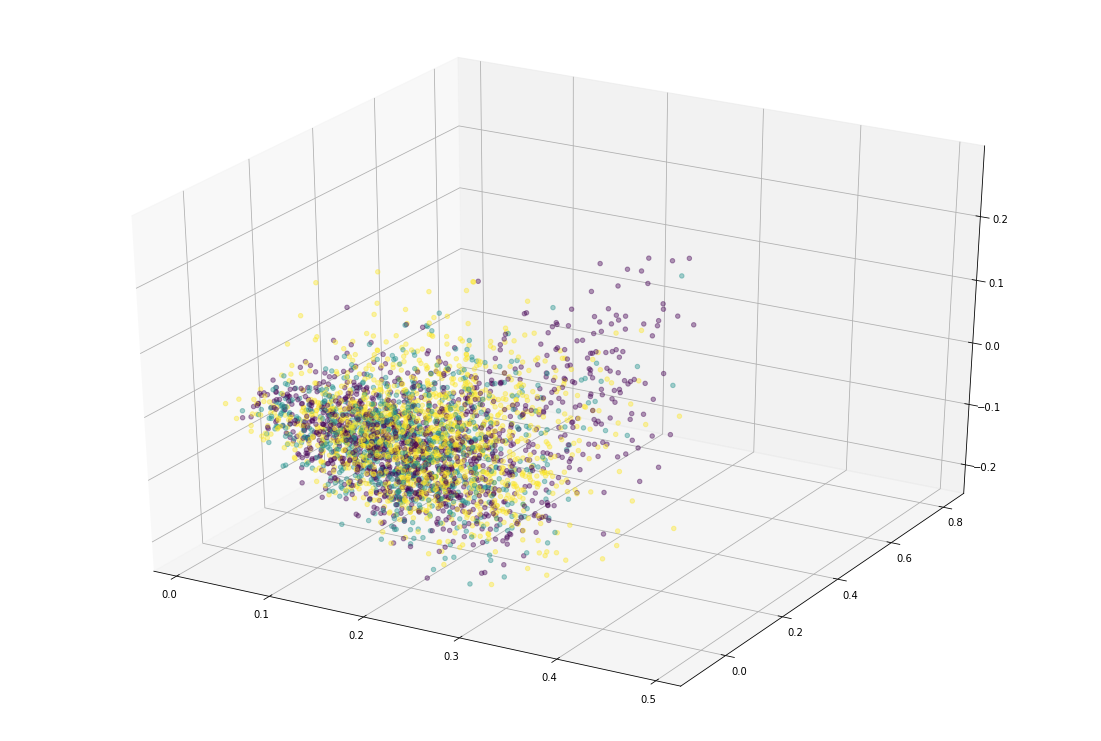

In [32]:
#plotting
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)                                                                 
ax.scatter(englishdata.xlabel,englishdata.ylabel,englishdata.zlabel,c=dominant_topic,alpha = 0.4)
plt.show()

# building a predictor

In [83]:
#combining the two dataframes.
newenglish2 = newenglish.append(neutral_post,ignore_index = True)

C:\Users\Daniel Sabba\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [84]:
#using default count vectorizer
bow = CountVectorizer()
#transforming the model
A = bow.fit_transform(newenglish2['WORKING_TEXT'])

In [85]:
#finding best model to predict with
clfs = [SVC(kernel='rbf',C=40),MultinomialNB(),KNeighborsClassifier(n_neighbors=7)]
for clf in clfs:
    scores=cross_validate(clf,A, newenglish2['DEPRESSED'],cv=10)
    print(np.mean(scores["test_score"]))

C:\Users\Daniel Sabba\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8851400861647157
0.9969729674069943
0.7802317662067104


In [18]:
#spliting to train and test
XTrain, XTest, yTrain, yTest = train_test_split(A, newenglish2['DEPRESSED'], random_state=1, test_size=0.2)
#chosing the best model and fitting the data
model = MultinomialNB()
model.fit(XTrain,yTrain)
yPred = model.predict(XTest)
#printing the confusion  matrix
print('model score and confusion matrix')
print(model.score(XTest,yTest))
print(confusion_matrix(yTest, yPred))

<bound method ClassifierMixin.score of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)>
[[193  10]
 [  0 722]]


## we can see that our predictor did a good job predicting with a 99% score